In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import time

In [174]:
##匯入資料
df_data_train = pd.read_csv("/home/jovyan/house sale price/train.csv")
df_data_test = pd.read_csv("/home/jovyan/house sale price/test.csv")
testID=df_data_test["Id"]

In [175]:
len(df_data_train.columns)

81

In [176]:
len(df_data_test.columns)

80

In [177]:
#missing data 
total = df_data_train.isnull().sum().sort_values(ascending=False)
percent = (df_data_train.isnull().sum()/df_data_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [178]:
test_total = df_data_test.isnull().sum().sort_values(ascending=False)
test_percent = (df_data_test.isnull().sum()/df_data_test.isnull().count()).sort_values(ascending=False)
test_missing_data = pd.concat([test_total, test_percent], axis=1, keys=['Total', 'Percent'])
test_missing_data.head(20)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageYrBlt,78,0.053461
GarageFinish,78,0.053461


In [179]:
df_data_train = df_data_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_data_train = df_data_train.drop(df_data_train.loc[df_data_train['Electrical'].isnull()].index)
df_data_train.isnull().sum().max()

0

In [180]:
df_data_test = df_data_test.drop((missing_data[missing_data['Total'] > 1]).index,1)

In [181]:
null_columns=df_data_test.columns[df_data_test.isnull().any()]
print(df_data_test[df_data_test.isnull().any(axis=1)][null_columns].head())

    MSZoning Utilities Exterior1st Exterior2nd  BsmtFinSF1  BsmtFinSF2  \
95        RL    AllPub     Wd Sdng     Wd Sdng         0.0         0.0   
455      NaN       NaN     Wd Sdng     Wd Sdng         0.0         0.0   
485       RL       NaN     BrkFace     BrkFace         0.0         0.0   
660       RM    AllPub     MetalSd      CBlock         NaN         NaN   
691       RL    AllPub         NaN         NaN      1035.0         0.0   

     BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath KitchenQual  \
95       689.0        689.0           0.0           0.0         NaN   
455        0.0          0.0           0.0           0.0          TA   
485     1632.0       1632.0           0.0           0.0          TA   
660        NaN          NaN           NaN           NaN          TA   
691      545.0       1580.0           1.0           0.0          Fa   

    Functional  GarageCars  GarageArea SaleType  
95         Mod         1.0       180.0      COD  
455       Min1         1.0  

In [182]:
#test data 處理missing value numerical
numeric_features = df_data_test.select_dtypes(include=[np.number])
numeric_features.columns
for col in (['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
             'GarageCars','GarageArea']):
    df_data_test[col]=df_data_test[col].fillna(0)

In [183]:
#test data 處理missing value categorical
for col in  ('Exterior1st','Exterior2nd','KitchenQual','SaleType'):
    df_data_test[col]=df_data_test[col].fillna(df_data_train[col].mode()[0])  

In [184]:
#deleting outliar points
df_data_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_data_train = df_data_train.drop(df_data_train[df_data_train['Id'] == 1299].index)
df_data_train = df_data_train.drop(df_data_train[df_data_train['Id'] == 524].index)

In [185]:
# normalize
#取log使其接近常態分佈
#applying log transformation
df_data_train['SalePrice'] = np.log(df_data_train['SalePrice'])

In [186]:
df_data_train['GrLivArea'] = np.log(df_data_train['GrLivArea'])

df_data_test['GrLivArea'] = np.log(df_data_test['GrLivArea'])

In [187]:
# deal with skewness
numerics=df_data_train.dtypes[df_data_train.dtypes !='object'].index
skewed= df_data_train[numerics].skew()
skewed= skewed[skewed>0.75]
skewed= skewed.index
df_data_train[skewed]=np.log1p(df_data_train[skewed])

df_data_test[skewed]=np.log1p(df_data_test[skewed])

In [169]:
x.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,...,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000
mean,3.817998,9.108554,6.094715,5.576527,1971.194235,1984.818806,4.227210,0.656748,5.647051,1052.995882,...,0.003432,0.082361,0.002059,0.868909,0.069321,0.002745,0.008236,0.013727,0.821551,0.084420
std,0.688812,0.513877,1.376542,1.113638,30.190353,20.640669,2.989447,1.846704,1.855629,414.754657,...,0.058500,0.275008,0.045345,0.337616,0.254086,0.052342,0.090410,0.116395,0.383022,0.278112
min,3.044522,7.170888,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.044522,8.928110,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,5.411646,796.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.931826,9.156306,6.000000,5.000000,1972.000000,1994.000000,5.950643,0.000000,6.173786,991.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.262680,9.358847,7.000000,6.000000,2000.000000,2004.000000,6.569481,0.000000,6.695799,1297.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5.252273,12.279537,10.000000,9.000000,2010.000000,2010.000000,7.691200,7.296413,7.756623,3206.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [170]:
df_data_test.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,3.822214,9.078854,6.078821,5.553804,1971.357779,1983.662783,4.220176,0.706567,5.602043,1045.400960,...,0.002056,0.080192,0.002742,0.86292,0.061001,0.005483,0.008225,0.017820,0.825223,0.082248
std,0.696730,0.501942,1.436812,1.113740,30.390071,21.130467,2.972605,1.911742,1.884929,443.592976,...,0.045314,0.271683,0.052306,0.34405,0.239414,0.073871,0.090348,0.132344,0.379907,0.274837
min,3.044522,7.293698,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.044522,8.908154,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,5.393628,784.000000,...,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.931826,9.148465,6.000000,5.000000,1973.000000,1992.000000,5.860786,0.000000,6.133398,988.000000,...,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.262680,9.351710,7.000000,6.000000,2001.000000,2004.000000,6.624057,0.000000,6.682735,1304.000000,...,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5.252273,10.943782,10.000000,9.000000,2010.000000,2010.000000,8.296796,7.331060,7.669028,5095.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Model(XGBOOST)
https://segmentfault.com/a/1190000014040317 <br/>
https://www.kaggle.com/goldens/regression-xgboost <br/>
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [203]:
%%capture
houses=pd.concat([df_data_train,df_data_test], sort=False)
houses=pd.get_dummies(houses)

In [204]:
train=houses[:len(df_data_train)]
test=houses[len(df_data_train):]
train.drop('Id', axis=1, inplace=True)
x=train.drop('SalePrice', axis=1) 
y=train['SalePrice'] 

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f2811addfd0>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [205]:
test.drop('Id', axis=1, inplace=True)
test=test.drop('SalePrice', axis=1)
test.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3.044522,9.360741,5,6,1961,1961,6.150603,4.976734,5.602119,882.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,9.565775,6,6,1958,1958,6.828712,0.000000,6.008813,1329.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,9.534668,5,5,1997,1998,6.674561,0.000000,4.927254,928.0,...,0,0,0,1,0,0,0,0,1,0
3,4.110874,9.208238,6,6,1998,1998,6.401917,0.000000,5.783825,926.0,...,0,0,0,1,0,0,0,0,1,0
4,4.795791,8.518392,8,5,1992,1992,5.575949,0.000000,6.925595,1280.0,...,0,0,0,1,0,0,0,0,1,0


In [206]:
housematrix=xgb.DMatrix(data=x, label=y)

In [266]:
xgb_param_grid = {'colsample_bytree':[0.05,0.07, 0.1 ,0.12, 0.15 , 0.2, 0.25, 0.3],'n_estimators':[300,400,500,600,700,800,900,1000],'max_depth':[2,3,4]}

In [267]:
xgb_inst= xgb.XGBRegressor(learning_rate=0.05)

In [268]:
xgb_grid = GridSearchCV(estimator= xgb_inst, param_grid = xgb_param_grid,scoring='neg_mean_squared_error', cv=5, verbose=1)

#scores_xgb=cross_val_score(xgb_grid,x,y,scoring='neg_mean_squared_error',cv=2)

In [269]:
start_time = time.time()

xgb_grid.fit(x,y)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:  8.9min finished


--- 534.9494521617889 seconds ---


In [16]:
scores_xgb=cross_val_score(xgb_grid,x,y,scoring='neg_mean_squared_error',cv=2)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.0min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.0min finished


In [33]:
scores_xgb

array([-0.01735577, -0.01495307])

In [270]:
#%%capture
xgb_grid.best_estimator_
#xgb_results = xgb_grid.cv_results_
#xgb_results

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=900,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [271]:
xgb_results = xgb_grid.cv_results_
max(xgb_results["mean_test_score"])

-0.01288508608121613

In [261]:
scores  = xgb_results['mean_test_score'].reshape(len(xgb_param_grid["colsample_bytree"]),
                                       len(xgb_param_grid["n_estimators"])*len(xgb_param_grid["max_depth"])) 

In [263]:
len(scores)

7

ValueError: num must be 1 <= num <= 4, not 5

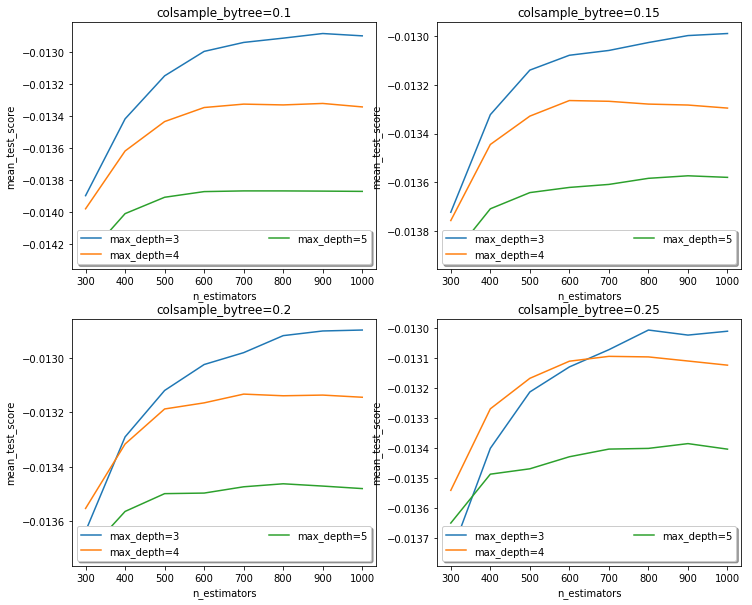

In [262]:
plt.figure(figsize=(12, 10))
rowcount=len(xgb_param_grid["n_estimators"]) #3
colcount=len(xgb_param_grid["max_depth"]) #4

for item in range(len(scores)):
    temp_item = scores[item].reshape(colcount, rowcount)
    plt.subplot(2,2,item+1)
    plt.title("colsample_bytree="+str(xgb_param_grid["colsample_bytree"][item]))
    plt.xlabel('n_estimators')
    plt.ylabel('mean_test_score')
    for i in range(len(temp_item)):
        plt.plot(xgb_param_grid["n_estimators"] , temp_item[i],label="max_depth="+str(xgb_param_grid["max_depth"][i]))
        leg =plt.legend(loc='lower center', ncol=2, mode="expand", shadow=True, fancybox=True)

plt.show()

In [272]:
import pickle

#保存Model
with open('xgb_grid.pickle', 'wb') as f:
    pickle.dump(xgb_grid, f)
   

'''
#读取Model
with open('xgb_grid.pickle', 'rb') as f:
    xgb_grid = pickle.load(f)
    #测试读取后的Model
    #print(xgb_grid.predict(X[0:1]))

'''

"\n#读取Model\nwith open('xgb_grid.pickle', 'rb') as f:\n    xgb_grid = pickle.load(f)\n    #测试读取后的Model\n    #print(xgb_grid.predict(X[0:1]))\n\n"

In [274]:
#df_data_test.head()
pred=xgb_grid.predict(test)
preds=np.exp(pred)

output = pd.DataFrame({'Id': testID,'SalePrice': preds})

In [275]:
output.to_csv('submission.csv', index=False) 

## 小結
2019/2/13 (1):
1. train data缺失值處理 : 大部分直接刪除
2. test data缺失值處理 : 使用mode 及補0
3. model : xgboost及 grid search <br/>
ps: pd.get_dummies() 需先將train data及test data concate
4. 正確率 0.1313 (1709/4072)

2019/2/13 (2):
1. 調整xgboost參數colsample_bytree=0.2, n_estimators=500, max_depth=3
2. mean_test_score = -0.0133
3. 正確率 0.12463 (1306/4072)

2019/2/13 (3):
1. 調整xgboost參數colsample_bytree=0.1, n_estimators=900, max_depth=3
2. mean_test_score = -0.01288
3. 正確率 0.12463 (1306/4072)